In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from torch.utils.data import DataLoader, TensorDataset
from functions import Solution, LV
from models import Autoencoder, integrator, network
from dynamical_models import PolySindyModel
import torch.nn.functional as F

In [118]:
b1, b2, a12, a21 = 2/3, 1, 4/3, 1
h = 0.1
t = np.arange(0, 100, h)
n = len(t)
x0 = [1, 1.5]
xs, ys = Solution(LV, x0, t, [b1, b2, a12, a21])
tau = 15

sol = Solution(LV, x0, t, [b1, b2, a12, a21])
library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_library=library,
                 optimizer=ps.STLSQ(threshold=0.05),
                 feature_names=["x", "y"])

model.fit(sol.T, t)
model.print()
LV_coefs = model.coefficients()

(x)' = 0.664 x + -1.329 x y
(y)' = -0.996 y + 0.996 x y


In [119]:
psindy = PolySindyModel(n_dimensions=2, degree=2, include_interaction=True, interaction_only=False, include_bias=True, mask=None)
system = psindy.poly_system
X = odeint(system, x0, t, args = (LV_coefs,))
x_input = X[:,0]
layer_dims = [2, 100, 40, 10, 2]
tstep_pred = 50

In [120]:
ode_model = integrator(tstep_pred, 0.1, system=system, init_params=np.zeros_like(LV_coefs)) # initiating parameters with 0s
encoder = network(layer_dims=layer_dims, activation= F.relu)
decoder = network(layer_dims=layer_dims[::-1], activation=F.relu)

optim_enc = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
optim_ode = torch.optim.Adam(ode_model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

In [121]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])

v = torch.tensor(np.array([v1, v2]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2]), dtype=torch.float32, requires_grad=True).T
dataset = TensorDataset(v, dvdt)
dataloader = DataLoader(dataset, batch_size=1500, shuffle=False)

In [122]:
torch.manual_seed(123)

In [123]:
sindyae = Autoencoder(tau, ode_model=ode_model, loss_fn=loss_fn, optim_enc=optim_enc, optim_ode=optim_ode, tstep_pred=tstep_pred,
                                  encoder=encoder, decoder=decoder,
                                  l={'x0':1, 'cons': 1, 'l1': 1e-1, 'recon': 1e-1, 'x_dot': 1e-1, 'v_dot': 1e-1})

In [124]:
for epoch in range(100):
    total_loss = 0
    for v_batch, dvdt_batch in dataloader:
        Loss = sindyae.loss(v_batch, dvdt_batch)
        Loss.backward()
        optim_enc.step()
        optim_ode.step()
        optim_enc.zero_grad()
        optim_ode.zero_grad()
        total_loss += Loss.item() 
    average_loss = total_loss / len(dataloader)
    if (epoch+1) % 10== 0:
         print(f"Epoch [{epoch+1}/{100}], Loss: {average_loss:.4f}")

Epoch [10/100], Loss: 1.6412
Epoch [20/100], Loss: 1.0170
Epoch [30/100], Loss: 0.6007
Epoch [40/100], Loss: 0.5971
Epoch [50/100], Loss: 0.7084
Epoch [60/100], Loss: 0.6164
Epoch [70/100], Loss: 0.5460
Epoch [80/100], Loss: 0.5485
Epoch [90/100], Loss: 0.5764
Epoch [100/100], Loss: 0.5820


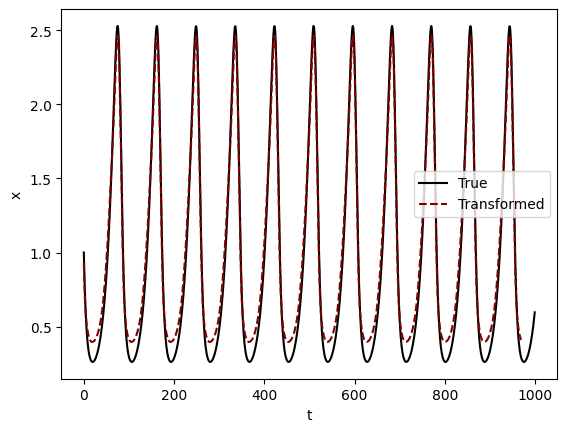

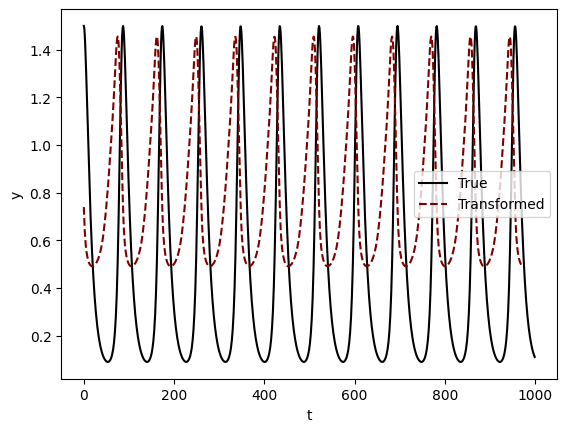

In [125]:
encoder.eval() 
ode_model.eval()
latent_variables = encoder(v)
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()


plt.plot(sol[0], color = "k", label = "True")
plt.plot(x_ae,color = "maroon", linestyle = 'dashed', label = "Transformed")
plt.ylabel("x")
plt.xlabel("t")
plt.legend()
plt.show()

plt.plot(sol[1], color = "k", label = "True")
plt.plot(y_ae,color = "maroon", linestyle = 'dashed', label = "Transformed")
plt.ylabel("y")
plt.xlabel("t")
plt.legend()
plt.show()